## Dataset

In [9]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.utils import set_seed
set_seed(3407)

In [10]:
import random

def random_add_instance(length):
    a = [random.randint(0,9) for i in range(length)]
    b = [random.randint(0,9) for i in range(length)]
    val_a = int(''.join(str(d) for d in a))
    val_b = int(''.join(str(d) for d in b))
    val_c = val_a + val_b
    str_c = str(val_c)
    str_c = (length + 1 - len(str_c)) * '0' + str_c
    return a + b + [int(d) for d in str_c]

for i in range(10):
    print (random_add_instance(3))



[0, 6, 2, 5, 3, 6, 0, 5, 9, 8]
[4, 9, 5, 3, 7, 8, 0, 8, 7, 3]
[6, 4, 4, 3, 1, 4, 0, 9, 5, 8]
[3, 5, 9, 1, 1, 9, 0, 4, 7, 8]
[3, 5, 0, 1, 4, 8, 0, 4, 9, 8]
[0, 0, 2, 9, 3, 7, 0, 9, 3, 9]
[8, 4, 8, 2, 3, 7, 1, 0, 8, 5]
[9, 9, 9, 7, 0, 6, 1, 7, 0, 5]
[7, 4, 5, 1, 3, 6, 0, 8, 8, 1]
[1, 0, 1, 0, 4, 2, 0, 1, 4, 3]


In [11]:
class AddDataset(Dataset):
    """ 
    Dataset for the Add problem. E.g. for problem length 3:
    12 + 333 = 345
    Input: 0 1 2 3 3 3 -> Output: 0 3 4 5
    Which will feed into the transformer concatenated as:
    input:  0 1 2 3 3 3 0 3 4
    output: I I I I I 0 3 4 5
    where I is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=3):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
    
    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return 10
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return 3 * self.length + 1 - 1

    def __getitem__(self, idx):
        while True:
            rai = random_add_instance(self.length)
            h = hash(str(rai[:2*self.length]))
            
            inp_split = 'test' if h % 4 == 0 else 'train' # designate 25% of examples as test
            if inp_split == self.split:
                break # ok
        
        x = torch.tensor(rai[:-1], dtype=torch.long)
        y = torch.tensor(rai[1:], dtype=torch.long)
        
        # we only want to predict at output locations, mask out the loss at the input locations
        y[:2*self.length-1] = -1
        return x, y

In [12]:
# print an example instance of the dataset
train_dataset = AddDataset('train')
test_dataset = AddDataset('test')
x, y = train_dataset[0]

print (x)
for a, b in zip(x,y):
    print(int(a),int(b))

tensor([2, 9, 3, 4, 8, 0, 0, 7, 7])
2 -1
9 -1
3 -1
4 -1
8 -1
0 0
0 7
7 7
7 3


## Model

In [146]:
# create a GPT instance
from mingpt.model import GPT

HEADS = 4
LAYERS = 4
EMBEDDING_DIM = 128

model_config = GPT.get_default_config()
model_config.model_type = None
# model_config.merge_from_dict({"model_type": None,
                            #   "n_heads": 4})
model_config.n_head = HEADS
model_config.n_layer = LAYERS
model_config.n_embd = EMBEDDING_DIM
print (model_config)
# model_config.model_type = 'gpt-nano'

model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model = GPT(model_config)

model_type: None
n_layer: 4
n_head: 4
n_embd: 128
vocab_size: None
block_size: None
embd_pdrop: 0.1
resid_pdrop: 0.1
attn_pdrop: 0.1

number of parameters: 0.80M


In [147]:
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if os.path.exists(f'../weights/static/st_add_{HEADS}_{LAYERS}_{EMBEDDING_DIM}.pth'):
    model.load_state_dict(torch.load(f'../weights/static/st_add_{HEADS}_{LAYERS}_{EMBEDDING_DIM}.pth', map_location=device))
    # print(model_config.n_heads, model_config.n_layers, model_config.n_embd)


/tmp/ipykernel_9066/285897140.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../weights/static/st_add_{HEADS}_{LAYERS}_{EMBEDDING_DIM

In [65]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 1e-8 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 5000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_dataset)

running on device cuda


## Training

In [66]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

iter_dt 0.00ms; iter 0: train loss 0.66380
iter_dt 11.49ms; iter 100: train loss 0.75406
iter_dt 10.77ms; iter 200: train loss 0.63195
iter_dt 10.71ms; iter 300: train loss 0.69717
iter_dt 11.45ms; iter 400: train loss 0.70431
iter_dt 11.42ms; iter 500: train loss 0.69730
iter_dt 12.32ms; iter 600: train loss 0.69624
iter_dt 11.56ms; iter 700: train loss 0.71214
iter_dt 12.10ms; iter 800: train loss 0.70718
iter_dt 11.55ms; iter 900: train loss 0.68875
iter_dt 10.88ms; iter 1000: train loss 0.69067
iter_dt 11.95ms; iter 1100: train loss 0.67345
iter_dt 13.29ms; iter 1200: train loss 0.67407
iter_dt 11.29ms; iter 1300: train loss 0.69311
iter_dt 12.77ms; iter 1400: train loss 0.68847
iter_dt 11.23ms; iter 1500: train loss 0.65660
iter_dt 11.29ms; iter 1600: train loss 0.65595
iter_dt 11.01ms; iter 1700: train loss 0.69083
iter_dt 12.54ms; iter 1800: train loss 0.65934
iter_dt 10.72ms; iter 1900: train loss 0.71100
iter_dt 13.26ms; iter 2000: train loss 0.68162
iter_dt 10.75ms; iter 2100

## Training Evaluation

In [67]:
# now let's perform some evaluation
model.eval()
None

In [68]:
c_vals = []
w_vals = []

def eval_add_split(trainer, split, max_batches):
    dataset = {'train':train_dataset, 'test':test_dataset}[split]
    n = train_dataset.length # naugy direct access shrug
    results = []
    mistakes_printed_already = 0
    loader = DataLoader(dataset, batch_size=100, num_workers=0, drop_last=False)
    #loader = DataLoader(dataset, batch_size=1, num_workers=0, drop_last=False)
    for b, (x, y) in enumerate(loader):
        x = x.to(trainer.device)
        y = y.to(trainer.device)

        inp = x[:, :2*n]
        sol = y[:, -n-1:]
        
        cat = model.generate(inp, n+1, do_sample=False) # using greedy argmax, not sampling
        sol_candidate = cat[:, -n-1:]         
        correct = (sol == sol_candidate).all(1).cpu() 
        incorrect = ~correct
        # print("Incorrect:", incorrect)
        c_vals.extend(sol[incorrect].tolist())
        w_vals.extend(sol_candidate[incorrect].tolist())
        # print(sol[incorrect].tolist())
        # mae = (sol[incorrect] - sol_candidate[incorrect])
        # print(mae.tolist())
        # errors.extend(mae.tolist())
        for i in range(x.size(0)):
            results.append(int(correct[i]))
    
    rt = torch.tensor(results, dtype=torch.float)
    print("%s final score: %d/%d = %.2f%% correct" % (split, rt.sum(), len(results), 100*rt.mean()))
    return rt.sum()

# run a lot of examples from both train and test through the model and verify the output correctness
with torch.no_grad():
    train_score = eval_add_split(trainer, 'train', max_batches=50)
    test_score  = eval_add_split(trainer, 'test',  max_batches=50)

train final score: 985/10000 = 9.85% correct
test final score: 930/10000 = 9.30% correct


In [20]:
errors = []

for c, w in zip(c_vals, w_vals):
    a = int(''.join(str(d) for d in c))
    b = int(''.join(str(d) for d in w))
    # print(a, b)
    # print(abs(a-b))
    errors.append(abs(a-b))

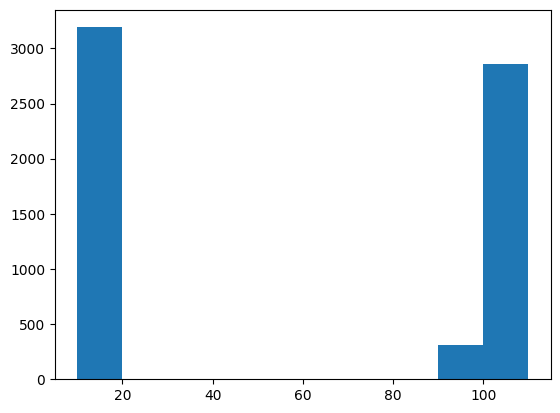

In [21]:
import matplotlib.pyplot as plt

# print (errors)

plt.hist(errors)
# plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])
plt.show()

In [45]:
torch.save(model.state_dict(), f'../weights/static/st_add_{HEADS}_{LAYERS}_{EMBEDDING_DIM}.pth')

## Evaluation

In [56]:
accuracy = []

heads_unique = [1, 2, 4]
layers_unique = [1, 2, 3, 4]

for heads in heads_unique:
    h_s = []
    for layers in layers_unique:
        model_config = GPT.get_default_config()
        model_config.model_type = None
        model_config.n_head = heads
        model_config.n_layer = layers
        model_config.n_embd = 128
        model_config.vocab_size = train_dataset.get_vocab_size()
        model_config.block_size = train_dataset.get_block_size()
        print (model_config)
        model = GPT(model_config)


        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.load_state_dict(torch.load(f'../weights/static/st_add_{heads}_{layers}_{128}.pth', map_location=device))

        train_config = Trainer.get_default_config()
        train_config.learning_rate = 1e-4 # the model we're using is so small that we can go a bit faster
        train_config.max_iters = 5000
        train_config.num_workers = 0
        trainer = Trainer(train_config, model, train_dataset)

        model.eval()

        with torch.no_grad():
            test_score  = eval_add_split(trainer, 'test',  max_batches=50)

        h_s.append(test_score.item())
    accuracy.append(h_s)


model_type: None
n_layer: 1
n_head: 1
n_embd: 128
vocab_size: 10
block_size: 9
embd_pdrop: 0.1
resid_pdrop: 0.1
attn_pdrop: 0.1

number of parameters: 0.20M
running on device cuda


/tmp/ipykernel_9066/2869324181.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../weights/static/st_add_{heads}_{layers}_{128}.pth', 

test final score: 6302/10000 = 63.02% correct
model_type: None
n_layer: 2
n_head: 1
n_embd: 128
vocab_size: 10
block_size: 9
embd_pdrop: 0.1
resid_pdrop: 0.1
attn_pdrop: 0.1

number of parameters: 0.40M
running on device cuda
test final score: 6860/10000 = 68.60% correct
model_type: None
n_layer: 3
n_head: 1
n_embd: 128
vocab_size: 10
block_size: 9
embd_pdrop: 0.1
resid_pdrop: 0.1
attn_pdrop: 0.1

number of parameters: 0.60M
running on device cuda
test final score: 9367/10000 = 93.67% correct
model_type: None
n_layer: 4
n_head: 1
n_embd: 128
vocab_size: 10
block_size: 9
embd_pdrop: 0.1
resid_pdrop: 0.1
attn_pdrop: 0.1

number of parameters: 0.80M
running on device cuda
test final score: 979/10000 = 9.79% correct
model_type: None
n_layer: 1
n_head: 2
n_embd: 128
vocab_size: 10
block_size: 9
embd_pdrop: 0.1
resid_pdrop: 0.1
attn_pdrop: 0.1

number of parameters: 0.20M
running on device cuda
test final score: 3936/10000 = 39.36% correct
model_type: None
n_layer: 2
n_head: 2
n_embd: 128
vo

[[6302.0, 6860.0, 9367.0, 979.0], [3936.0, 9558.0, 9808.0, 9788.0], [6284.0, 9721.0, 9650.0, 9883.0]]


/tmp/ipykernel_9066/3341687491.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(layers_unique))
/tmp/ipykernel_9066/3341687491.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(heads_unique))


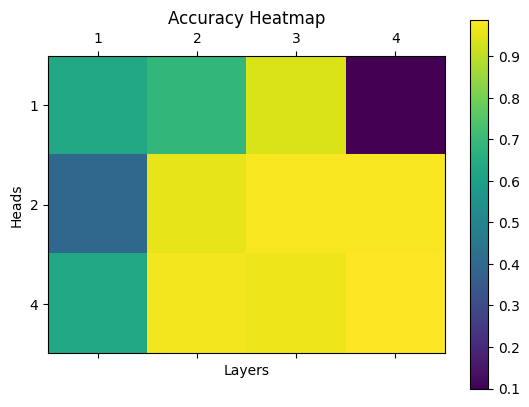

In [59]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
# Reshape accuracy data for heatmap
# accuracy_matrix = np.array([score[2] for score in accuracy]).reshape(len(layers_unique), len(heads_unique))

print (accuracy)
scores = np.array(accuracy) / 10000

# Plot heatmap
fig, ax = plt.subplots()
cax = ax.matshow(scores, cmap='viridis')

# Add color bar
fig.colorbar(cax)

# Set axis labels
ax.set_xticklabels([''] + list(layers_unique))
ax.set_yticklabels([''] + list(heads_unique))
ax.set_xlabel('Layers')
ax.set_ylabel('Heads')

# Set title
plt.title('Accuracy Heatmap')
plt.show()

## Visualization

tensor([[0, 8, 2, 7, 1, 5, 0, 7, 9]])
tensor([[8, 2, 7, 1, 5, 0, 7, 9, 7]])
torch.Size([1, 4, 9, 9])


RuntimeError: a Tensor with 9 elements cannot be converted to Scalar

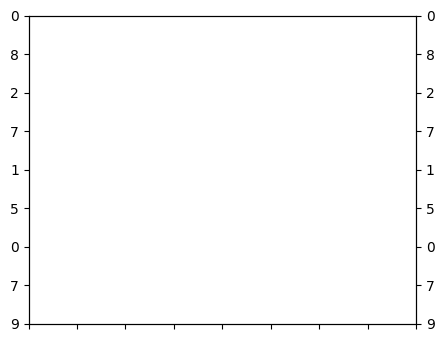

In [166]:
import torch
import numpy as np

attentions = []
device = torch.device("cpu")

# Define a random input tensor
input_tensor = test_dataset[0][0].unsqueeze(0).to(device)
cut_tensor = input_tensor[:, :6]
output_tensor = model.generate(cut_tensor, 4, do_sample=False)
output_tensor = output_tensor[:, 1:]
print(input_tensor)
print(output_tensor)

# Pass the input tensor through the embedding layers
input_emb = model.transformer.wte(input_tensor) + model.transformer.wpe(torch.arange(input_tensor.size(1), device=device))

words = [str(i.item()) for i in input_tensor[0]][::-1]
words_y = [str(i.item()) for i in output_tensor[0]][::-1]
# Pass through the transformer layers
for layer in model.transformer.h:
    # Layer normalization
    normed_input = layer.ln_1(input_emb)
    B, T, C = normed_input.size()
    
    # Self-attention
    attn_weights = layer.attn.c_attn(normed_input)
    q, k, v = attn_weights.split(model_config.n_embd, dim=2)

    k = k.view(B, T, HEADS, C // HEADS).transpose(1, 2) # (B, nh, T, hs)
    q = q.view(B, T, HEADS, C // HEADS).transpose(1, 2) # (B, nh, T, hs)
    v = v.view(B, T, HEADS, C // HEADS).transpose(1, 2) # (B, nh, T, hs)

    attn_scores = (q @ k.transpose(-2, -1)) * (1.0 / np.sqrt(k.size(-1)))
    attn_probs = torch.nn.functional.softmax(attn_scores, dim=-1)
    print(attn_probs.size())

    # print(attn_probs[0, 0, 0].item())
    n = attn_probs.size(-1)

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels([])
    ax.set_yticklabels(words)
    ax2 = ax.twinx()
    ax2.set_yticks(range(n))
    ax2.set_yticklabels(words)
    # Draw lines for attention weights
    for i in range(n):
        for j in range(n):
            if attn_probs[0, i, j].item() > 0.5:  # Threshold for visibility
                ax.plot([0, n-1], [i, j], 'b-', alpha=attn_probs[0, i, j].item())

    ax.set_title("Transformer Attention Visualization")
    plt.show()

    attn_output = attn_probs @ v
    attn_output = layer.attn.c_proj(attn_output)
    
    # Residual connection and dropout
    input_emb = input_emb + layer.attn.resid_dropout(attn_output)
    
    # Layer normalization
    normed_input = layer.ln_2(input_emb)
    
    # Feed-forward network
    ff_output = layer.mlp.c_fc(normed_input)
    ff_output = layer.mlp.act(ff_output)
    ff_output = layer.mlp.c_proj(ff_output)
    
    # Residual connection and dropout
    input_emb = input_emb + layer.mlp.dropout(ff_output)

# Final layer normalization
output_emb = model.transformer.ln_f(input_emb)

# Linear layer to get logits
logits = model.lm_head(output_emb)

# Get the predicted token
predicted_token = torch.argmax(logits, dim=-1)

print("Input Tensor:", input_tensor)
print("Predicted Token:", predicted_token)

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

# Assuming the model has an attribute `transformer.h` which is a list of layers
# and each layer has an attribute `attn` which has the attention weights

def plot_attention(model, layer, head):
    attn_weights = model.transformer.h[layer].attn.c_attn.weight.detach().cpu().numpy()
    q, k, v = np.split(attn_weights, 3, axis=0)
    
    att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size))
    print(attn_weights.shape)
    print(q.shape, k.shape, v.shape)
    print(att.shape)


    # sns.heatmap(attn_weights, cmap='viridis')
    # plt.title(f'Attention Weights - Layer {layer+1}, Head {head+1}')
    # plt.xlabel('Key Position')
    # plt.ylabel('Query Position')
    # plt.show()

# Plot attentions for all layers and heads
for layer in range(LAYERS):
    for head in range(HEADS):
        plot_attention(model, layer, head)

(384, 128)
(128, 128) (128, 128) (128, 128)
(128, 128)
(384, 128)
(128, 128) (128, 128) (128, 128)
(128, 128)
(384, 128)
(128, 128) (128, 128) (128, 128)
(128, 128)
(384, 128)
(128, 128) (128, 128) (128, 128)
(128, 128)


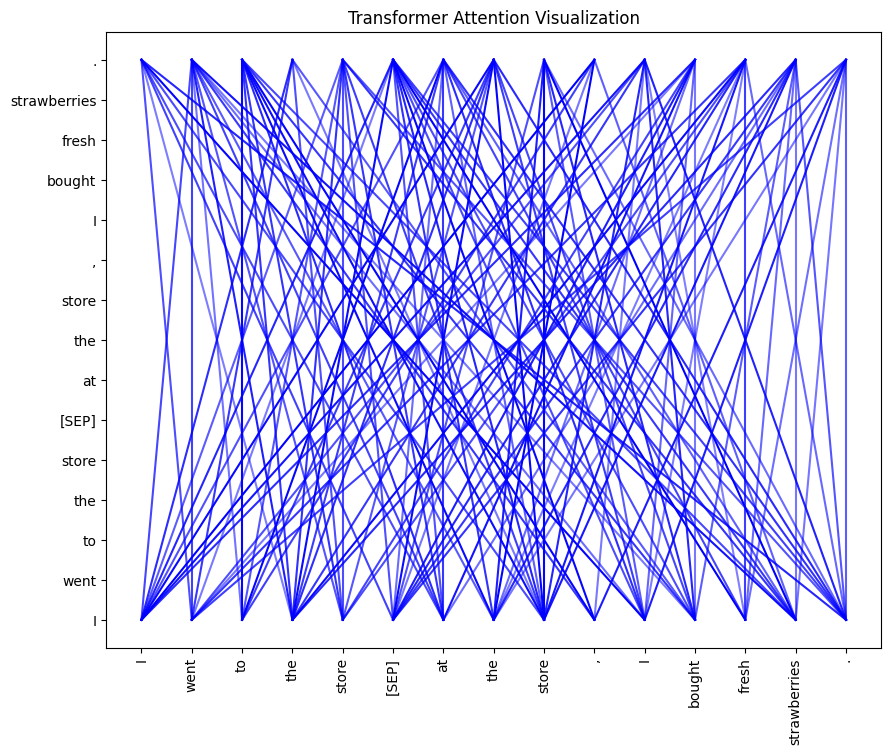

In [124]:
import matplotlib.pyplot as plt
import numpy as np

# Sample words
words = ["I", "went", "to", "the", "store", "[SEP]", "at", "the", "store", ",", "I", "bought", "fresh", "strawberries", "."]
n = len(words)

# Generate random attention scores
attention = np.random.rand(n, n)

# Plot attention connections
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(words, rotation=90)
ax.set_yticklabels(words)

# Draw lines for attention weights
for i in range(n):
    for j in range(n):
        if attention[i, j] > 0.5:  # Threshold for visibility
            ax.plot([i, j], [0, n-1], 'b-', alpha=attention[i, j])

ax.set_title("Transformer Attention Visualization")
plt.show()

